In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle

In [2]:
def parse_data_file(filename, filters=[], do_not_load_data=False):
    """ Read a Qudi ".dat" data file and return the parameters, columns and data parsed

    @param string filename: the file to read
    @param list(function) filters: list of functions to filter
    @param (bool) do_not_load_data: Force the function to return only the parameters and the columns

    @return tuple dict(parameters), list(columns), numpy_2d_array(data)

    This function :
    1. First read the parameters of the file line by line to construct a dictionary of the parameters.
    2. Check if all the filters return True when given the built dictionary
    3. Build an list of the data columns keys
    4. Load the data via numpy.loadtxt() (or use pandas.read_csv() if first option fails)

    Function return None if filtered out

    Data is always returned as a 2d numpy array.
    """
    # 1.
    try:
        file = open(filename, "r")
    except FileNotFoundError:
        raise FileNotFoundError('The file specified does not exist.')
    line = file.readline()
    last_line = ''  # last line will be the data keys
    parameters = {}
    while line[0] == '#':  # read line by line as long as the line start by a #
        line = line[1:]  # remove the '#' character
        pair = line.split('=')
        if len(pair) == 2:  # if line is a key value pair
            key, value = pair
            if key not in ['Parameters', 'Data']:  # Do not confuse these two lines with a parameter
                try:
                    value = float(value)
                except ValueError:  # If value can not be parsed as a float, use a string
                    value = str.strip(value)
                parameters[key] = value
        last_line = line
        line = file.readline()
    # 2.
    for filter in filters:  # If the filter applied on the parameters return False, do not load
        if not filter(parameters):
            return None
    # 3.
    columns = last_line.split('\t')
    columns = [column.strip() for column in columns]
    if '' in columns:  # Can occur because of \t at the end of the line
        columns.remove('')

    if do_not_load_data:
        return parameters, columns, None
    # 4.
    try:
        data = np.loadtxt(filename)
    except ValueError:  # If file can not be parsed, probably because there is a string in the data.
        # Let's use pandas read_csv instead, we will get array of objects instead of numbers
        try:
            data = pd.read_csv(filename, comment='#', sep='\t', header=None).values
        except ValueError:
            print('Can not read file {}, something is wrong with it. File ignored.'.format(filename))
            return
    if data.ndim == 1:
        data = data[np.newaxis, :]
    elif data.ndim == 2:
        data = data.transpose()
    else:
        raise ValueError('The number of dimension of this file is neither 1 or 2.')
    return parameters, columns, data

In [3]:
def get_serie_from_file(filename, filters=[]):
    """ Get a pandas Series corresponding to a single file

    @param (str) filename: the file to read
    @param list(function) filters: list of functions to filter out files before full loading (see parse_data_file)

    @return pandas.Series: Panda series representing the data file

    Each parameter will lead to a key in the series index with its corresponding value
    Each data column will lead to a key in the series index with the 1d numpy array as value

    A '_raw_data' column is created containing the full 2d array extracted from numpy.loadtxt method.
    A '_path' column is created containing a reference to the pathlib.Path object
    A '_timestamp' column is created containing timestamp based on the filename

    Return None if filtered out
    """
    parsed = parse_data_file(filename, filters=filters)
    if parsed is None:
        return None
    dictionary, columns, data = parsed
    if len(columns) == len(data):  # if the file is a list of 1d array
        for i, column in enumerate(columns):
            dictionary.update({column: data[i]})
    dictionary.update({'_raw_data': data})
    dictionary.update({'_path': Path(filename)})
    dictionary.update({'_timestamp': pd.to_datetime(Path(filename).stem[0:16], format='%Y%m%d-%H%M-%S')})
    return pd.Series(dictionary)


def get_dataframe_from_files(files, filters=[]):
    """ Get a pandas Dataframe from a list of files

    @param list(str) files: files path
    @param list(function) filters: list of functions to filter out files before full loading (see parse_data_file)

    @return pandas.DataFrame: Panda DataFrame containing all the data, one row per file
    """
    if isinstance(files, str):  # In case only one file has be given directly as a string (instead of a list)
        files = [files]
    series = []
    for file in files:
        serie = get_serie_from_file(file, filters=filters)
        if serie is not None:
            series.append(serie)
    return pd.DataFrame(series)


def get_dataframe_from_folders(folders, filters=[], recursively=True, pattern='*.dat'):
    """ Get a pandas Dataframe from one or multiple folders

    @param list(str) folders: folders path
    @param list(function) filters: list of functions to filter out files before full loading (see parse_data_file)
    @param (bool) recursively: Whether all the sub-folders should be parsed as well
    @param (str) pattern: The pattern fed to glob to filter files by name

    @return (pandas.DataFrame): Pandas DataFrame containing all the data, one row per file

    pattern can be used to filter out folders like : 'Counter/*.dat' will only match .dat file inside a Counter folder.
    See Python glob for more information
    """
    if isinstance(folders, str):  # In case only one file has be given directly as a string (instead of a list)
        folders = [folders]
    total_files = []
    for folder in folders:
        method = Path(folder).rglob if recursively else Path(folder).glob
        files = list(method(pattern))
        total_files.extend(files)
    return get_dataframe_from_files(total_files, filters=filters)

In [4]:
from ast import literal_eval
# Function to convert string representation of tuple to tuple
def str_to_tuple(s):
    try:
        return literal_eval(s)
    except (ValueError, SyntaxError) as e:
        return None  # Return None if conversion fails

In [5]:
import pandas as pd
pd.options.display.max_rows = 150
pd.options.display.max_columns = 150

---
# DATA

In [6]:
folder = r"C:\Users\YB274940\qudi\Data\2024\03\2024-03-28"
data = get_dataframe_from_folders(folder)

In [7]:
data

,timestamp,comments,delimiter,column_dtypes,column_headers,x axis name,x axis unit,x scan range,x axis resolution,x axis min,x axis max,y axis name,y axis unit,y scan range,y axis resolution,y axis min,y axis max,pixel frequency,scanner target at start,measurement start,z axis name,z axis unit,_raw_data,_path,_timestamp
0,2024-03-28T08:49:00.892666,'# ','\t',float;;float;;float;;float;;float;;float;;floa...,"'Image (columns is X, rows is Y)'",'x','m',"(-0.0001, 0.0001)",601.0,-0.0001,0.0001,'y','m',"(-6e-05, 6e-05)",361.0,-0.00006,0.00006,1.0,"{'x': 0.0, 'y': 0.0, 'z': -7e-09}",'2024-03-27 17:50:51.651527','z','m',"[[0.0, 0.0, 50.0, 0.0, 50.0, 150.0, 100.0, 0.0...",C:\Users\YB274940\qudi\Data\2024\03\2024-03-28...,2024-03-28 08:49:00
1,2024-03-28T08:49:01.852613,'# ','\t',float;;float;;float;;float;;float;;float;;floa...,"'Image (columns is X, rows is Y)'",'x','m',"(-0.0001, 0.0001)",601.0,-0.0001,0.0001,'y','m',"(-6e-05, 6e-05)",361.0,-0.00006,0.00006,1.0,"{'x': 0.0, 'y': 0.0, 'z': -7e-09}",'2024-03-27 17:50:51.651527','z','m',"[[0.0, 0.0, 50.0, 0.0, 50.0, 150.0, 100.0, 0.0...",C:\Users\YB274940\qudi\Data\2024\03\2024-03-28...,2024-03-28 08:49:01
2,2024-03-28T08:49:02.283777,'# ','\t',float;;float;;float;;float;;float;;float;;floa...,"'Image (columns is X, rows is Y)'",'x','m',"(-0.0001, 0.0001)",601.0,-0.0001,0.0001,'y','m',"(-6e-05, 6e-05)",361.0,-0.00006,0.00006,1.0,"{'x': 0.0, 'y': 0.0, 'z': -7e-09}",'2024-03-27 17:50:51.651527','z','m',"[[0.0, 0.0, 50.0, 0.0, 50.0, 150.0, 100.0, 0.0...",C:\Users\YB274940\qudi\Data\2024\03\2024-03-28...,2024-03-28 08:49:02
3,2024-03-28T09:01:55.736924,'# ','\t',float;;float;;float;;float;;float;;float;;floa...,"'Image (columns is X, rows is Y)'",'x','m',"(-0.0001, 0.0001)",601.0,-0.0001,0.0001,'y','m',"(-6e-05, 6e-05)",361.0,-0.00006,0.00006,1.0,"{'x': 0.0, 'y': 0.0, 'z': -7e-09}",'2024-03-27 17:50:51.651527','z','m',"[[0.0, 0.0, 50.0, 0.0, 50.0, 150.0, 100.0, 0.0...",C:\Users\YB274940\qudi\Data\2024\03\2024-03-28...,2024-03-28 09:01:55
4,2024-03-28T09:01:56.734783,'# ','\t',float;;float;;float;;float;;float;;float;;floa...,"'Image (columns is X, rows is Y)'",'x','m',"(-0.0001, 0.0001)",601.0,-0.0001,0.0001,'y','m',"(-6e-05, 6e-05)",361.0,-0.00006,0.00006,1.0,"{'x': 0.0, 'y': 0.0, 'z': -7e-09}",'2024-03-27 17:50:51.651527','z','m',"[[0.0, 0.0, 50.0, 0.0, 50.0, 150.0, 100.0, 0.0...",C:\Users\YB274940\qudi\Data\2024\03\2024-03-28...,2024-03-28 09:01:56
5,2024-03-28T09:01:57.645727,'# ','\t',float;;float;;float;;float;;float;;float;;floa...,"'Image (columns is X, rows is Y)'",'x','m',"(-0.0001, 0.0001)",601.0,-0.0001,0.0001,'y','m',"(-6e-05, 6e-05)",361.0,-0.00006,0.00006,1.0,"{'x': 0.0, 'y': 0.0, 'z': -7e-09}",'2024-03-27 17:50:51.651527','z','m',"[[0.0, 0.0, 50.0, 0.0, 50.0, 150.0, 100.0, 0.0...",C:\Users\YB274940\qudi\Data\2024\03\2024-03-28...,2024-03-28 09:01:57
6,2024-03-28T09:01:58.111202,'# ','\t',float;;float;;float;;float;;float;;float;;floa...,"'Image (columns is X, rows is Y)'",'x','m',"(-0.0001, 0.0001)",601.0,-0.0001,0.0001,'y','m',"(-6e-05, 6e-05)",361.0,-0.00006,0.00006,1.0,"{'x': 0.0, 'y': 0.0, 'z': -7e-09}",'2024-03-27 17:50:51.651527','z','m',"[[0.0, 0.0, 50.0, 0.0, 50.0, 150.0, 100.0, 0.0...",C:\Users\YB274940\qudi\Data\2024\03\2024-03-28...,2024-03-28 09:01:58


---
# PLOT

In [8]:
def params_for_plot(data, data_line):
    v_min, v_max = 0.1, 200
    
    x_scan_range = data[" x scan range"].apply(str_to_tuple)
    x_min = x_scan_range[data_line][0]
    x_max = x_scan_range[data_line][1]
    
    y_scan_range = data[" y scan range"].apply(str_to_tuple)
    y_min = y_scan_range[data_line][0]
    y_max = y_scan_range[data_line][1]
    
    extent = (x_min, x_max, y_min, y_max)
    
    scalebar_x_max = x_max - 185e-6
    scalebar_x_min = scalebar_x_max - 10e-6
    scalebar_y_max = y_min - y_min * 0.15
    scalebar_y_min = scalebar_y_max
    scalebar_text_x = scalebar_x_min
    scalebar_text_y = scalebar_y_min - scalebar_y_min * 0.05
    scalebar_text_fontsize = 12
    
    params_dict = {
        'v_min': v_min,
        'v_max': v_max,
        'x_min': x_min,
        'x_max': x_max,
        'y_min': y_min,
        'y_max': y_max,
        'extent': extent,
        'scalebar_x_max': scalebar_x_max,
        'scalebar_x_min': scalebar_x_min,
        'scalebar_y_max': scalebar_y_max,
        'scalebar_y_min': scalebar_y_min,
        'scalebar_text_x': scalebar_text_x,
        'scalebar_text_y': scalebar_text_y,
        'scalebar_text_fontsize': scalebar_text_fontsize
    }
    
    return params_dict

In [9]:
def plot_line_from_dataframe(ax, data_line, params_dict):
    data_to_plot = data["_raw_data"][data_line][::-1] / 1e3
    
    # Add a small offset to avoid zeros in the data
    offset = 1e-10
    data_to_plot = np.where(data_to_plot == 0, offset, data_to_plot)
    
    # Plot 2D scan
    im = ax.imshow(data_to_plot, cmap='inferno', extent=params_dict['extent'], 
#                    vmin=params_dict['v_min'], vmax=params_dict['v_max'], )
                   norm=LogNorm( vmin=params_dict['v_min'], vmax=params_dict['v_max']))
    
    # Plot scale bar
    ax.plot([params_dict['scalebar_x_min'], params_dict['scalebar_x_max']], 
            [params_dict['scalebar_y_min'], params_dict['scalebar_y_max']], 
            color='white', linewidth=2)
    
    # Add scale bar text
    ax.text(params_dict['scalebar_text_x'], params_dict['scalebar_text_y'], 
            '10 µm', color='white', fontsize=params_dict['scalebar_text_fontsize'])
    
    
# =================================================
#     data_bg = data_to_plot[30:360,0:50]
#     print(data_bg.mean())
    
#     # Create a Rectangle patch
#     rect = Rectangle((params_dict['x_min'], params_dict['y_min']+30e-6*0.333), 50e-6*0.333, 330e-6*0.333, 
#                      linewidth=1, edgecolor='r', facecolor='none')
#     # Add the patch to the Axes
#     ax.add_patch(rect)
# =================================================
    
    
    ax.set_xticks([])
    ax.set_yticks([])

    return im

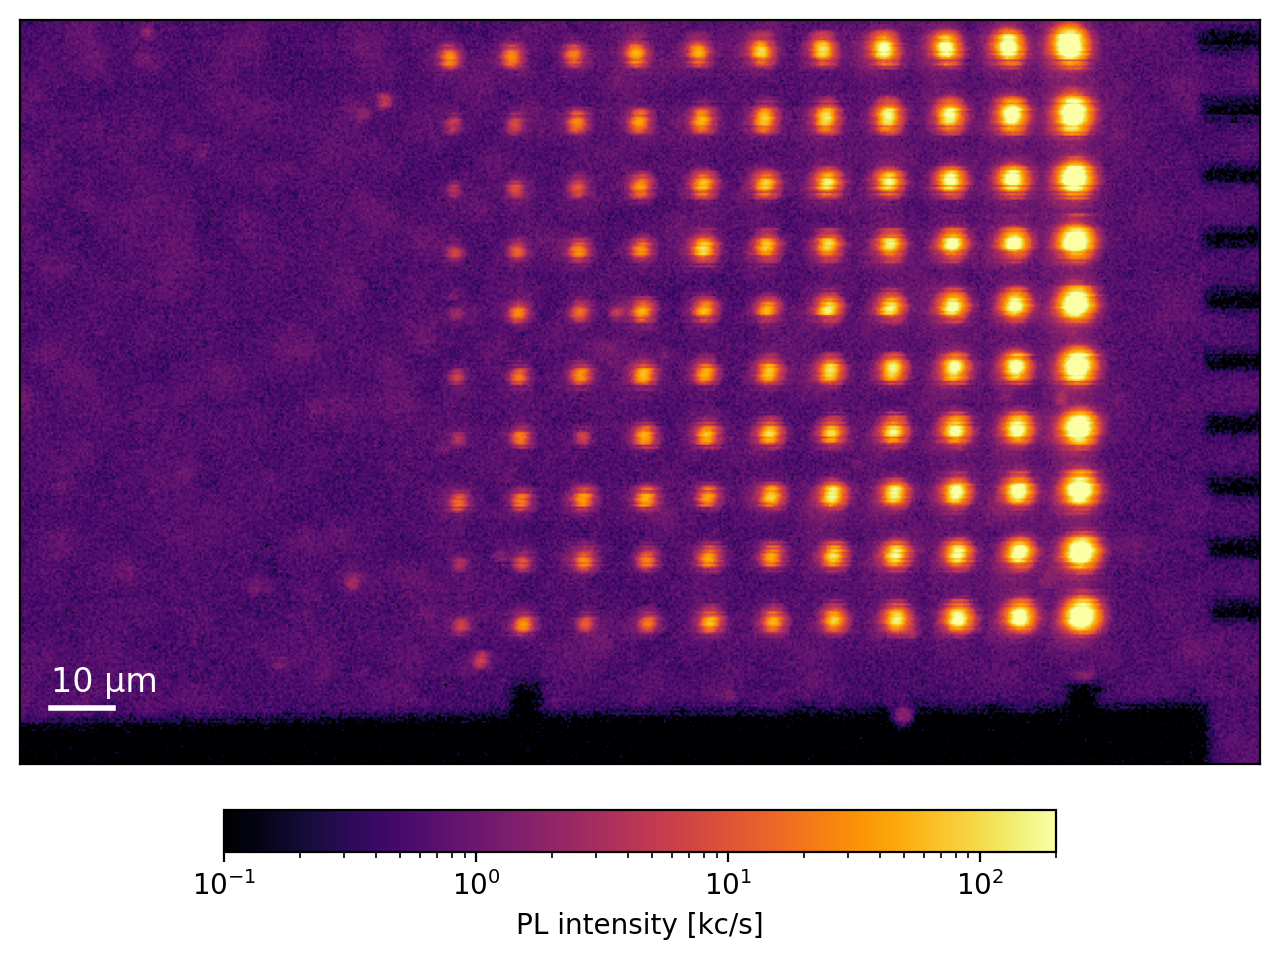

In [10]:
data_line = 0
params_dict = params_for_plot(data, data_line)

fig, axs = plt.subplots(figsize=(8,6))
im = plot_line_from_dataframe(axs, data_line, params_dict)

cbar = fig.colorbar(im, orientation='horizontal', ax=axs, fraction=0.045, shrink=1.0, aspect=20, pad=0.05)
cbar.set_label('PL intensity [kc/s]')

fig.dpi=200
pass

In [11]:
# for i in range(10):
#     fig, axs = plt.subplots(figsize=(4,4))
#     im = plot_line_from_dataframe(axs, i, params_dict)

#     cbar = fig.colorbar(im, ax=axs, fraction=0.045, shrink= 1.0, aspect=20, pad=0.05)
#     cbar.set_label('PL intensity [kc/s]')
#     plt.show()
#     fig.dpi=200
    
# pass

In [12]:
# fig, axs = plt.subplots(2, 2)

# ims = {}
# for i, (row, col, data_line, text_to_plot) in enumerate([(0, 0, 0, '1e11 Si/cm²')
#                                                          , (0, 1, 1, '1e10 Si/cm²')
#                                                          , (1, 0, 3, '1e09 Si/cm²')
#                                                          , (1, 1, 5, '1e08 Si/cm²')]):
#     params_dict = params_for_plot(data, data_line)
#     im = plot_line_from_dataframe(axs[row, col], data_line, params_dict)
#     axs[row, col].text(params_dict['x_min']+1e-6, params_dict['y_max']-2e-6, text_to_plot, color='black', bbox=dict(facecolor='white', alpha=0.6), fontsize=6)
#     ims[(row, col)] = im

# # Create a common colorbar based on the last plot's colormap
# cbar = fig.colorbar(ims[(1, 1)], ax=axs, fraction=0.045, shrink=1.0, aspect=20, pad=0.05, )
# cbar.set_label('PL intensity [kc/s]')

# fig.suptitle('T = 300 °C', x=0.52, y=1.0, fontsize=8)
# fig.dpi = 200
# pass

In [13]:
# fig, axs = plt.subplots(1, 4, figsize=(8,4))

# ims = {}
# for i, (row, col, data_line, text_to_plot) in enumerate([(0, 0, 1, '1e11 Si/cm²')
#                                                          , (0, 1, 3, '1e10 Si/cm²')
#                                                          , (0, 2, 4, '1e09 Si/cm²')
#                                                          , (0, 3, 5, '1e08 Si/cm²')]):
#     params_dict = params_for_plot(data, data_line)
#     im = plot_line_from_dataframe(axs[col], data_line, params_dict)
#     axs[col].text(params_dict['x_min']+1e-6, params_dict['y_max']-2e-6, text_to_plot, color='black', bbox=dict(facecolor='white', alpha=0.6), fontsize=6)
#     ims[col] = im

# # Create a common colorbar based on the last plot's colormap
# cbar = fig.colorbar(ims[3], ax=axs, fraction=0.045, shrink=1.0, aspect=20, pad=0.05, )
# cbar.set_label('PL intensity [kc/s]')

# fig.suptitle('T = 300 °C', x=0.52, y=1.0, fontsize=8)
# fig.dpi = 200
# pass

In [14]:
# fig, axs = plt.subplots(1, 4, figsize=(8, 4))

# ims = {}
# for i, (row, col, data_line, text_to_plot) in enumerate([(0, 0, 0, 'T$_{anneal}$ = 200 °C'),
#                                                          (0, 1, 1, 'T$_{anneal}$ = 250 °C'),
#                                                          (0, 2, 2, 'T$_{anneal}$ = 300 °C'),
#                                                          (0, 3, 4, 'T$_{anneal}$ = 350 °C')]):
#     params_dict = params_for_plot(data, data_line)
#     im = plot_line_from_dataframe(axs[col], data_line, params_dict)
#     axs[col].text(params_dict['x_min'] + 0.6*params_dict['x_max'], params_dict['y_max'] - 0.11*params_dict['y_max'], 
#                   text_to_plot, color='black', bbox=dict(facecolor='white', alpha=0.6), fontsize=6)
#     ims[col] = im

# # Create a common colorbar based on the last plot's colormap
# cbar = fig.colorbar(ims[3], orientation='horizontal', ax=axs, fraction=0.045, shrink=1.0, aspect=20, pad=0.05)
# cbar.set_label('PL intensity [kc/s]')

# fig.suptitle('Fluence: 1e11 Si/cm² at Room-T', x=0.5, y=0.62, fontsize=8)
# fig.dpi = 200
# plt.show()

---
# SELECT SUBDATA

In [15]:
scan = data["_raw_data"][0][::-1] / 1e3

# Create x and y indices
x_values = np.linspace(params_dict['extent'][0], params_dict['extent'][1], 601)
y_values = np.linspace(params_dict['extent'][2], params_dict['extent'][3], 361)
x, y = np.meshgrid(x_values, y_values)

In [21]:
# #SELECT COLUMN FOR ANAYLSIS
# i_col = 211
# i_range = 15
# print(f"Position in µm: {x_values[i_col]*1e6}")

# scan_per_col = []
# for i in range(i_col-i_range, i_col+i_range):
#     scan_col = scan[:,i]
#     scan_per_col.append(scan_col)

# scan_per_col = np.array(scan_per_col)
# scan_col_avg = np.sum(scan_per_col, axis=0)

In [20]:
# fig, ax = plt.subplots(dpi=100, figsize=(4, 3))

# ax.tick_params(direction='in', which='both')
# ax.plot(y_values*1e6, scan_col_avg)
# ax.set_xlim(-60, 60)
# ax.set_xlabel('Position [µm]')
# pass

In [19]:
# data_line = 0
# params_dict = params_for_plot(data, data_line)

# fig, ax = plt.subplots(dpi=200, figsize=(8, 6))
# im = plot_line_from_dataframe(ax, data_line, params_dict)
# ax.axvline(x=x_values[i_col], color='white', ls='--', lw=.5)
# ax.axvline(x=x_values[i_col-i_range], color='white', ls='--', lw=.5)
# ax.axvline(x=x_values[i_col+i_range], color='white', ls='--', lw=.5)

# cbar = fig.colorbar(im, orientation='horizontal', ax=axs, fraction=0.045, shrink=1.0, aspect=20, pad=0.05)
# cbar.set_label('PL intensity [kc/s]')
# pass

In [22]:
#SELECT LINE FOR ANAYLSIS
i_lin = 259
i_range = 14
print(y_values[i_lin])

scan_per_lin = []
for i in range(i_lin-i_range, i_lin+i_range):
    scan_lin = scan[i]
    scan_per_lin.append(scan_lin)

scan_per_lin = np.array(scan_per_lin)
scan_lin_avg = np.sum(scan_per_lin, axis=0)

2.6333333333333334e-05


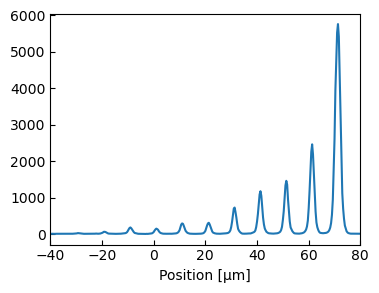

In [23]:
fig, ax = plt.subplots(dpi=100, figsize=(4, 3))
ax.tick_params(direction='in', which='both')
ax.plot(x_values*1e6, scan_lin_avg)
ax.set_xlim(-40, 80)
ax.set_xlabel('Position [µm]')
# ax.set_yscale('log')
# ax.set_ylim(0, 1000)
pass

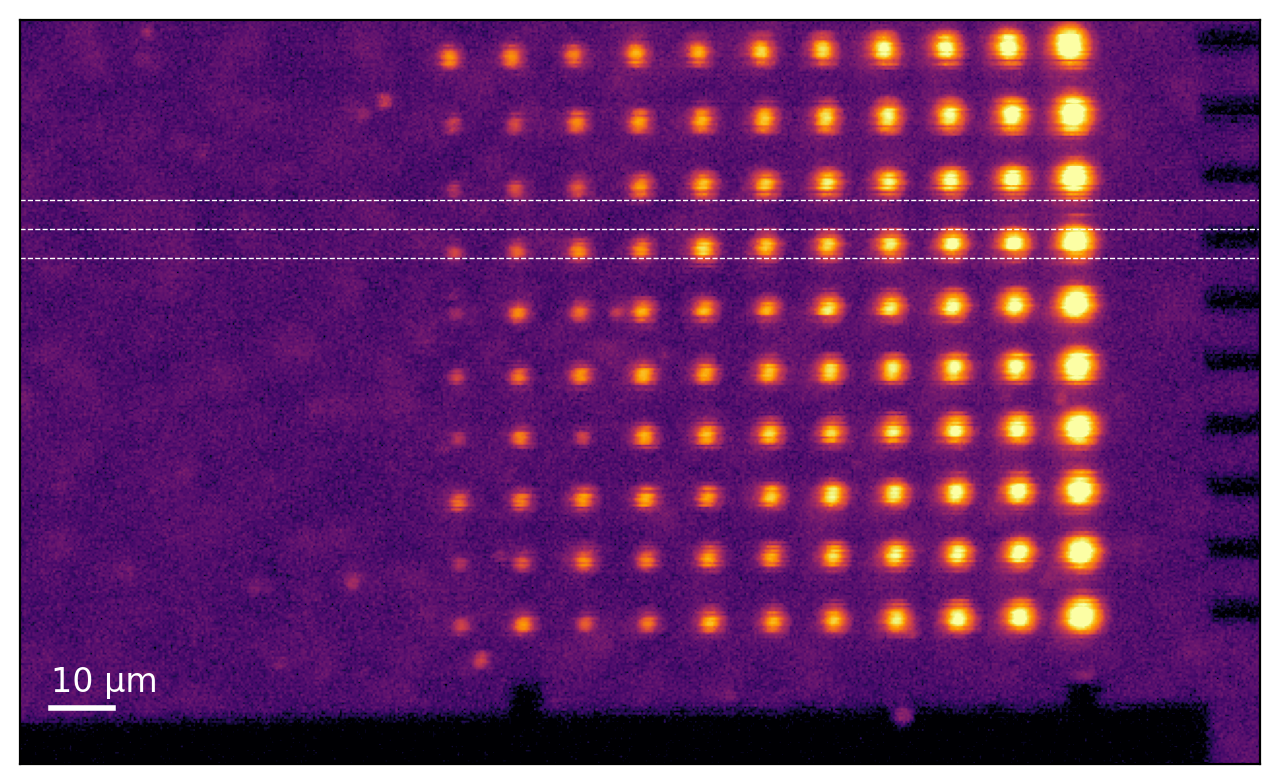

In [24]:
data_line = 0
params_dict = params_for_plot(data, data_line)

fig, ax = plt.subplots(dpi=200, figsize=(8, 6))
im = plot_line_from_dataframe(ax, data_line, params_dict)
ax.axhline(y=y_values[i_lin], color='white', ls='--', lw=.5)
ax.axhline(y=y_values[i_lin-i_range], color='white', ls='--', lw=.5)
ax.axhline(y=y_values[i_lin+i_range], color='white', ls='--', lw=.5)

cbar = fig.colorbar(im, orientation='horizontal', ax=axs, fraction=0.045, shrink=1.0, aspect=20, pad=0.05)
cbar.set_label('PL intensity [kc/s]')
pass

---
# FIT

In [25]:
from lmfit.models import GaussianModel, ConstantModel

In [26]:
df=pd.DataFrame(index=x_values)
df['peaks'] = scan_lin_avg

In [27]:
# FIT N GAUSSIAN
# create a model with 3 Gaussians: pretty easy to generalize to a loop to make N peaks
N = 11
model = ConstantModel(prefix='bg_') + GaussianModel(prefix='p1_')
for i in range(2, N+1):
    model += GaussianModel(prefix='p'+str(i)+'_')

params = model.make_params(c=15,
                           p1_center=-29, p1_amplitude=50, p1_sigma=1,
                           p2_center=-19, p2_amplitude=100, p2_sigma=1,
                           p3_center=-9, p3_amplitude=100, p3_sigma=1,
                           p4_center=1, p4_amplitude=600, p4_sigma=1,
                           p5_center=11, p5_amplitude=800, p5_sigma=1,
                           p6_center=21, p6_amplitude=1000, p6_sigma=1,
                           p7_center=31, p7_amplitude=1300, p7_sigma=1,
                           p8_center=41, p8_amplitude=2200, p8_sigma=1,
                           p9_center=51, p9_amplitude=2800, p9_sigma=1,
                           p10_center=61, p10_amplitude=4900, p10_sigma=1,
                           p11_center=71, p11_amplitude=14400, p11_sigma=1)

# # Parameters can have min/max bounds, be fixed (`.vary = False`)
# # or constrained to a mathematical expression of other Parameter values
params['bg_c'].min = 10
params['bg_c'].max = 20

for i in range(N):
    params['p'+str(i+1)+'_center'].min = -35
    params['p'+str(i+1)+'_center'].max = 80
    params['p'+str(i+1)+'_amplitude'].min = 20
    params['p'+str(i+1)+'_sigma'].min = .5
    params['p'+str(i+1)+'_sigma'].max = 2

# run the fit
result = model.fit(df['peaks'], params, x=df.index)

# print out the fit results
print(result.fit_report())

[[Model]]
    (((((((((((Model(constant, prefix='bg_') + Model(gaussian, prefix='p1_')) + Model(gaussian, prefix='p2_')) + Model(gaussian, prefix='p3_')) + Model(gaussian, prefix='p4_')) + Model(gaussian, prefix='p5_')) + Model(gaussian, prefix='p6_')) + Model(gaussian, prefix='p7_')) + Model(gaussian, prefix='p8_')) + Model(gaussian, prefix='p9_')) + Model(gaussian, prefix='p10_')) + Model(gaussian, prefix='p11_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2626
    # data points      = 601
    # variables        = 34
    chi-square         = 2.0703e+08
    reduced chi-square = 365129.953
    Akaike info crit   = 7730.61356
    Bayesian info crit = 7880.16578
    R-squared          = 2.9182e-05
##  Warning: uncertainties could not be estimated:
    p1_amplitude:   at initial value
    p1_center:      at initial value
    p1_sigma:       at initial value
    p2_amplitude:   at initial value
    p2_center:      at initial value
    p2_sigma:       at in

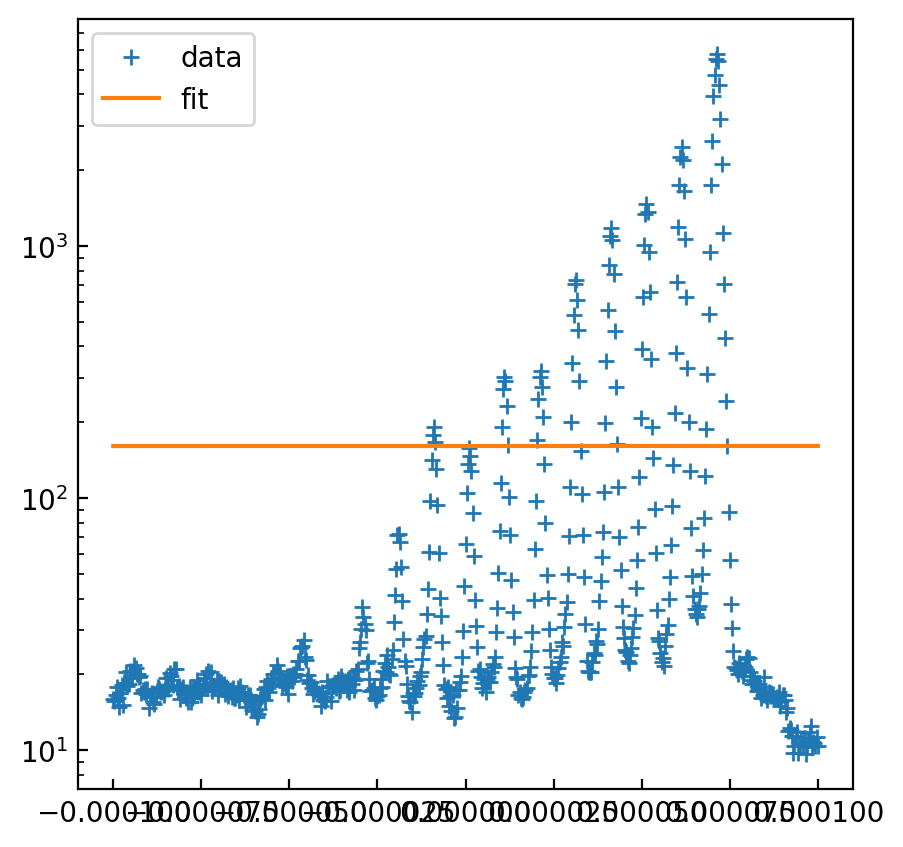

In [28]:
# plot results
fig, ax = plt.subplots(dpi=200, figsize=(5, 5))

ax.plot(df.index, df['peaks'], '+', label='data')
ax.plot(df.index, result.best_fit, '-', label='fit')

ax.tick_params(direction='in', which='both')
ax.set_yscale('log')
plt.legend()
pass

In [ ]:

#%%CUSTOM LOG SCALE
x = np.linspace(xmin, xmax, 601)
y = np.linspace(ymax, ymin, 361)
x, y = np.meshgrid(x, y)

index_xmin = 0
index_xmax = 320
index_ymin = 150
index_ymax = 550

scan_zoom = scan[index_xmin:index_xmax, index_ymin:index_ymax]
x_zoom = x[index_xmin:index_xmax, index_ymin:index_ymax]
y_zoom = y[index_xmin:index_xmax, index_ymin:index_ymax]
xmin_zoom = x_zoom[0,0]
xmax_zoom = x_zoom[0,-1]
ymin_zoom = y_zoom[-1,0]
ymax_zoom = y_zoom[0,0]
print(xmin_zoom)
print(xmax_zoom)
print(ymin_zoom)
print(ymax_zoom)

scan_custom = 255 * np.log10(scan_zoom) / np.log10(np.max(scan_zoom))

fig, ax = plt.subplots( dpi=600, figsize=(5, 5) )
divider = make_axes_locatable(ax)
ax_bar = divider.append_axes('right',size=.2, pad=.05)
im = ax.imshow(scan_custom, cmap='gray', vmin=0, vmax=255, extent=[xmin_zoom, xmax_zoom, ymin_zoom, ymax_zoom], aspect='equal')

cbar = fig.colorbar(im, cax=ax_bar, label='Counts [Mcps]', orientation='vertical')
ax_bar.yaxis.tick_right()
ax_bar.yaxis.set_label_position('right')
cbar.ax.tick_params(direction='in', which='both')

ax.set_xlabel('x (µm)')
ax.set_ylabel('y (µm)')

# ax.set_xlim(-50, 80)
# ax.set_ylim(-45, 60)


In [ ]:
#%%LINEAR SCALE BLACK AND WHITE
fig, ax = plt.subplots( dpi=600, figsize=(5, 5) )
divider = make_axes_locatable(ax)
ax_bar = divider.append_axes('right',size=.2, pad=.05)
im = ax.imshow(scan, cmap='gray', vmax=None, extent=[xmin, xmax, ymin, ymax], aspect='equal')

cbar = fig.colorbar(im, cax=ax_bar, label='Counts [Mcps]', orientation='vertical')
ax_bar.yaxis.tick_right()
ax_bar.yaxis.set_label_position('right')
cbar.ax.tick_params(direction='in', which='both')

ax.set_xlabel('x (µm)')
ax.set_ylabel('y (µm)')

# ax.set_xlim(-50, 25)
# ax.set_ylim(50, 65)

In [ ]:

#%%LINEAR SCALE BLACK AND WHITE ON A SELECTED AREA
x_values = np.linspace(-100, 100, 601)
y_values = np.linspace(-60, 60, 361)

i_ymax = 208
i_ymin = 300
i_xmin = 325
i_xmax = 513

scan_zoom = scan[208:395,325:513]

#plot raw scan with data selection
fig, ax = plt.subplots( dpi=300, figsize=(5, 5) )
divider = make_axes_locatable(ax)
ax_bar = divider.append_axes('right',size=.2, pad=.05)
maxmax = 1e3#np.max(scan)
minmin = 1e0
im = ax.imshow(scan, vmin=minmin, vmax=maxmax, cmap='inferno', extent=[xmin, xmax, ymin, ymax], aspect='equal', norm=mpl.colors.LogNorm())
cbar = fig.colorbar(im, cax=ax_bar, label='PL intensity [kcps]', orientation='vertical')
ax_bar.yaxis.tick_right()
ax_bar.yaxis.set_label_position('right')
cbar.ax.tick_params(direction='in', which='both')
# ax.set_xlabel('x (µm)')
# ax.set_ylabel('y (µm)')
ax.set_xlim(-50, 80)
ax.set_ylim(-50, 60)
# ax.set_xticks([])
# ax.set_yticks([])
ax.vlines(x_values[i_xmin], ymin=-50, ymax=60, color='white', ls='--')
ax.vlines(x_values[i_xmax], ymin=-50, ymax=60, color='white', ls='--')
ax.hlines(y_values[i_ymin], xmin=-50, xmax=80, color='white', ls='--')
ax.hlines(y_values[i_ymax], xmin=-50, xmax=80, color='white', ls='--')

#plot select area
fig, ax = plt.subplots( dpi=600, figsize=(5, 5) )
divider = make_axes_locatable(ax)
ax_bar = divider.append_axes('right',size=.2, pad=.05)
im = ax.imshow(scan_zoom, cmap='gray', vmax=None, extent=[xmin, xmax, ymin, ymax], aspect='equal')

cbar = fig.colorbar(im, cax=ax_bar, label='Counts [Mcps]', orientation='vertical')
ax_bar.yaxis.tick_right()
ax_bar.yaxis.set_label_position('right')
cbar.ax.tick_params(direction='in', which='both')

ax.set_xlabel('x (µm)')
ax.set_ylabel('y (µm)')

# ax.set_xlim(-50, 25)
# ax.set_ylim(50, 65)

# test

In [7]:
import numpy as np
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

In [37]:
def find_maxima(image, distance, prominence):
    peaks, _ = find_peaks(image.ravel(), distance=distance, prominence=prominence)
    peaks_coords = np.unravel_index(peaks, image.shape)
    return peaks_coords

def gaussian_2d(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    x, y = xy
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
    b = -(np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
    c = (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
    g = offset + amplitude * np.exp( - (a * ((x-xo)**2) + 2 * b * (x-xo) * (y-yo) + c * ((y-yo)**2)))
    return g.ravel()

def fit_gaussian_2d(image, initial_guess):
    x = np.arange(0, image.shape[1])
    y = np.arange(0, image.shape[0])
    xx, yy = np.meshgrid(x, y)
    xy = (xx, yy)
    
    popt, pcov = curve_fit(gaussian_2d, xy, image.ravel(), p0=initial_guess)
    
    return popt

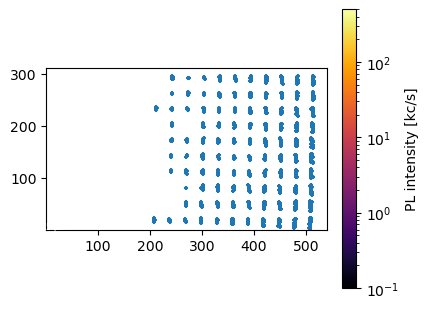

In [64]:
def params_for_plot(data, data_line):
    v_min, v_max = 0.1, 500
    
    x_scan_range = data[" x scan range"].apply(str_to_tuple)
    x_min = x_scan_range[data_line][0]
    x_max = x_scan_range[data_line][1]
    
    y_scan_range = data[" y scan range"].apply(str_to_tuple)
    y_min = y_scan_range[data_line][0]
    y_max = y_scan_range[data_line][1]
    
    extent = (x_min, x_max, y_min, y_max)
    
    scalebar_x_max = x_max - x_max * 0.2
    scalebar_x_min = scalebar_x_max - 5e-6
    scalebar_y_max = y_min - y_min * 0.2
    scalebar_y_min = scalebar_y_max
    scalebar_text_x = scalebar_x_min + scalebar_x_min * 0.01
    scalebar_text_y = scalebar_y_min - scalebar_y_min * 0.1
    scalebar_text_fontsize = 6 if x_max == 20e-6 else 6
    
    params_dict = {
        'v_min': v_min,
        'v_max': v_max,
        'x_min': x_min,
        'x_max': x_max,
        'y_max': y_max,
        'extent': extent,
        'scalebar_x_max': scalebar_x_max,
        'scalebar_x_min': scalebar_x_min,
        'scalebar_y_max': scalebar_y_max,
        'scalebar_y_min': scalebar_y_min,
        'scalebar_text_x': scalebar_text_x,
        'scalebar_text_y': scalebar_text_y,
        'scalebar_text_fontsize': scalebar_text_fontsize
    }
    
    return params_dict

def plot_maxima(ax, maxima_coords):
    ax.plot(maxima_coords[1], maxima_coords[0], 'r+', markersize=10)

def plot_scalebar(ax, params_dict):
    ax.plot([params_dict['scalebar_x_min'], params_dict['scalebar_x_max']], 
            [params_dict['scalebar_y_min'], params_dict['scalebar_y_max']], 
            color='white', linewidth=2)
    ax.text(params_dict['scalebar_text_x'], params_dict['scalebar_text_y'], 
            '5 µm', color='white', fontsize=params_dict['scalebar_text_fontsize'])

def plot_gaussian(ax, max_coord, popt):
    ax.plot(max_coord[1], max_coord[0], 'bo')  # Plot the center of the Gaussian
    ax.text(max_coord[1], max_coord[0], f'({popt[1]:.2f}, {popt[2]:.2f})', color='white', fontsize=8)  # Add text with coordinates

def plot_line_from_dataframe(ax, data_line, params_dict):
    data_to_plot = data["_raw_data"][data_line][::-1] / 1e3
    
    # Add a small offset to avoid zeros in the data
    offset = 1e-10
    data_to_plot = np.where(data_to_plot == 0, offset, data_to_plot)
    im = ax.imshow(data_to_plot, cmap='inferno', extent=params_dict['extent'], 
                   norm=LogNorm(vmin=params_dict['v_min'], vmax=params_dict['v_max']))
    
    # Find maxima
    maxima_coords = find_maxima(data_to_plot, distance=1, prominence=10)

    # Plot maxima onto the imshow image
    ax.scatter(maxima_coords[1], maxima_coords[0], s=10, marker='+')

    # Plot other elements like scale bar if needed
    plot_scalebar(ax, params_dict)
    
    return im, data_to_plot, maxima_coords

# Main plotting code
fig, axs = plt.subplots(figsize=(4,4))

params_dict = params_for_plot(data, data_line)
im, data_to_plot, maxima_coords = plot_line_from_dataframe(axs, 0, params_dict)  # Retrieve data_to_plot and maxima_coords here

# Fit 2D Gaussian to each maximum
# for max_coord in zip(*maxima_coords):
#     initial_guess = [data_to_plot[max_coord], max_coord[1], max_coord[0], 10, 10, 0, 0]
#     popt = fit_gaussian_2d(data_to_plot, initial_guess)
#     plot_gaussian(axs, max_coord, popt)

cbar = fig.colorbar(im, ax=axs, fraction=0.045, shrink= 1.0, aspect=20, pad=0.05)
cbar.set_label('PL intensity [kc/s]')

plt.show()
fig.dpi=200


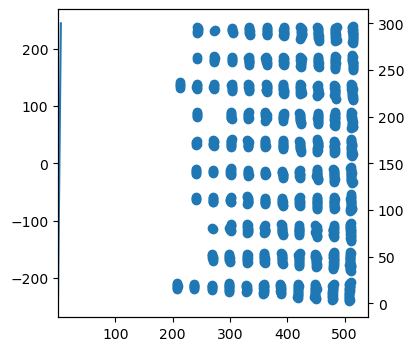

In [76]:
fig, ax = plt.subplots(figsize=(4,4))

data_to_plot = data["_raw_data"][0][::-1] / 1e3
    
    # Add a small offset to avoid zeros in the data
offset = 1e-10

data_to_plot = np.where(data_to_plot == 0, offset, data_to_plot)
im = ax.imshow(data_to_plot, cmap='inferno', extent=params_dict['extent'], 
               norm=LogNorm(vmin=params_dict['v_min'], vmax=params_dict['v_max']))

# ax.set_aspect("equal", "box-forced")
ax21 = ax.twinx()


ax21.scatter(maxima_coords[1], maxima_coords[0])
ax21.plot([0,5], [0,300])



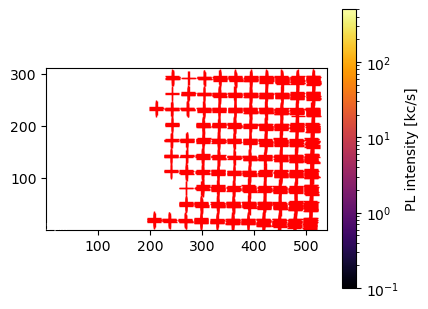

In [48]:
def plot_line_from_dataframe(ax, data_line, params_dict):
    data_to_plot = data["_raw_data"][data_line][::-1] / 1e3
    
    # Add a small offset to avoid zeros in the data
    offset = 1e-10
    data_to_plot = np.where(data_to_plot == 0, offset, data_to_plot)
    im = ax.imshow(data_to_plot, cmap='inferno', extent=params_dict['extent'], 
                   norm=LogNorm(vmin=params_dict['v_min'], vmax=params_dict['v_max']))
    
    # Find maxima
    maxima_coords = find_maxima(data_to_plot,1,10)

    # Plot maxima onto the imshow image
    ax.plot(maxima_coords[1], maxima_coords[0], 'r+', markersize=10)

    # Plot other elements like scale bar if needed
    plot_scalebar(ax, params_dict)
    
    return im

# Main plotting code
fig, axs = plt.subplots(figsize=(4,4))

params_dict = params_for_plot(data, data_line)
im = plot_line_from_dataframe(axs, 0, params_dict)  # Retrieve data_to_plot and maxima_coords here

# Fit 2D Gaussian to each maximum
# for max_coord in zip(*maxima_coords):
#     initial_guess = [data_to_plot[max_coord], max_coord[1], max_coord[0], 10, 10, 0, 0]
#     popt = fit_gaussian_2d(data_to_plot, initial_guess)
#     plot_gaussian(axs, max_coord, popt)

cbar = fig.colorbar(im, ax=axs, fraction=0.045, shrink= 1.0, aspect=20, pad=0.05)
cbar.set_label('PL intensity [kc/s]')

plt.show()
fig.dpi=200


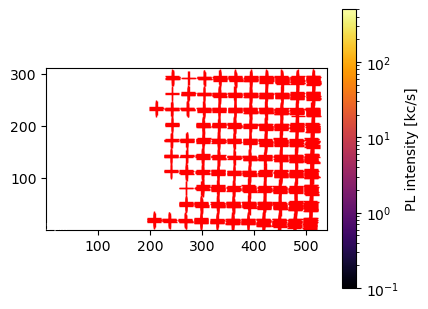

In [50]:
def plot_line_from_dataframe(ax, data_line, params_dict):
    data_to_plot = data["_raw_data"][data_line][::-1] / 1e3
    
    # Add a small offset to avoid zeros in the data
    offset = 1e-10
    data_to_plot = np.where(data_to_plot == 0, offset, data_to_plot)
    im = ax.imshow(data_to_plot, cmap='inferno', extent=params_dict['extent'], 
                   norm=LogNorm(vmin=params_dict['v_min'], vmax=params_dict['v_max']))
    
    # Plot other elements like scale bar if needed
    plot_scalebar(ax, params_dict)
    
    return im, data_to_plot

# Main plotting code
fig, axs = plt.subplots(figsize=(4,4))

params_dict = params_for_plot(data, data_line)
im, data_to_plot = plot_line_from_dataframe(axs, 0, params_dict)  # Retrieve data_to_plot here

# Find maxima
maxima_coords = find_maxima(data_to_plot,1,10)

# Plot maxima onto the imshow image
axs.plot(maxima_coords[1], maxima_coords[0], 'r+', markersize=10)

# Fit 2D Gaussian to each maximum
# for max_coord in zip(*maxima_coords):
#     initial_guess = [data_to_plot[max_coord], max_coord[1], max_coord[0], 10, 10, 0, 0]
#     popt = fit_gaussian_2d(data_to_plot, initial_guess)
#     plot_gaussian(axs, max_coord, popt)

cbar = fig.colorbar(im, ax=axs, fraction=0.045, shrink= 1.0, aspect=20, pad=0.05)
cbar.set_label('PL intensity [kc/s]')

plt.show()
fig.dpi=200


In [ ]:
# import cv2
# import numpy as np

# def find_maxima(image):
#     # Convert image to grayscale
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
#     # Apply a maximum filter to find local maxima
#     kernel_size = 5
#     max_filtered = cv2.dilate(gray, np.ones((kernel_size, kernel_size), np.uint8))
    
#     # Threshold to obtain binary image of local maxima
#     _, max_binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
#     max_binary[max_binary != max_filtered] = 0
    
#     # Find contours of the local maxima
#     contours, _ = cv2.findContours(max_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     maxima = [cv2.minEnclosingCircle(cnt) for cnt in contours]
    
#     return maxima

# # Example usage
# image = cv2.imread(r'C:\Users\YB274940\Desktop\test.png')
# maxima = find_maxima(image)

# # Draw circles around the maxima
# for center, radius in maxima:
#     center = tuple(map(int, center))
#     cv2.circle(image, center, int(radius), (0, 255, 0), 2)

# # Show the image with maxima highlighted
# cv2.imshow('Maxima', image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
